In [ ]:
!pip install -r requirements.txt

In [1]:
%matplotlib ipympl
import numpy as np
import scipy.spatial as sp
import trimesh
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import multiprocessing
from sklearn.neighbors import NearestNeighbors

workers = multiprocessing.cpu_count()
np.set_printoptions(linewidth=100)

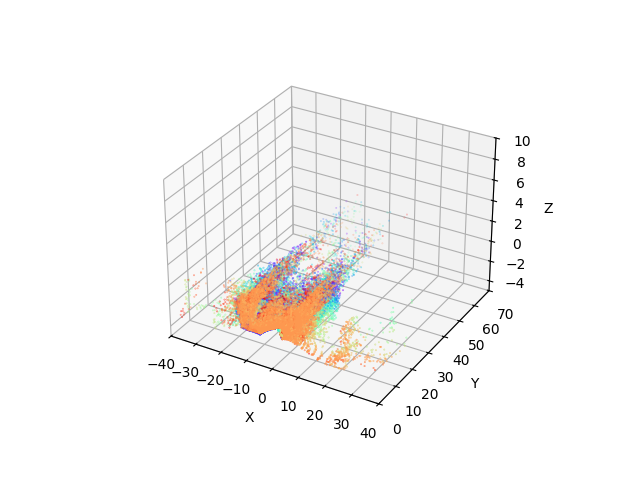

In [2]:
num_of_frames = 30
ax = plt.figure().add_subplot(projection='3d')
point_clouds = []
colors = cm.rainbow(np.linspace(0, 1, num_of_frames))
# Carregando todas as point clouds
for index in range(0, num_of_frames):
    # Usando operador ternario para avaliar se é necessário o 0 a mais
    file_name = "./KITTI-Sequence/0000"+ (("0" + str(index)) if index < 10 else str(index) )+"_points.obj"
    point_cloud = trimesh.load(file_name).vertices
    point_clouds.append(point_cloud)
    size = len(point_cloud)
    choices = np.random.choice(size, size=2000, replace=False)
    #print(p)
    x = point_cloud.T[0][choices]
    y = point_cloud.T[1][choices]
    z = point_cloud.T[2][choices]
    ax.scatter(x, y, z, s=0.1, color=colors[index])

ax.set_xlim(-40, 40)
ax.set_ylim(0, 70)
ax.set_zlim(-5, 10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [4]:
def icp(source_points, target_points, epsilon = 1e-7, leafsize = 1, balanced_tree=True, max_iter = 100):

    def register_points(a, b):
        '''
        Cashbaugh, Jasmine & Kitts, C.. (2018). 
        Automatic Calculation of a Transformation Matrix Between Two Frames. 
        IEEE Access. PP. 1-1. 10.1109/ACCESS.2018.2799173. 
        '''
        a1 = np.column_stack((a,np.ones(a.shape[0])))
        b1 = np.column_stack((b,np.ones(b.shape[0])))

        matrixA = np.tensordot(a1,a1.T,axes=[0,1])
        matrixR = np.tensordot(a1,b1.T,axes=[0,1])
        matrixAinv = np.linalg.inv(matrixA)
        return np.tensordot(matrixAinv,matrixR,axes=1).transpose() 

    '''
    
    def register_points(source, target):
        # ICP & Point Cloud Registration - Part 1: Known Data Association & SVD:
        # https://youtu.be/dhzLQfDBx2Q
        # source.shape == (N x 3)
        # target.shape == (M x 3)

        # cm = center of mass
        source_cm = np.average(source, axis=0).reshape((3,1)) # (3,1)
        target_cm = np.average(target, axis=0).reshape((3,1)) # (3,1)

        # mr = mean-reduced
        source_mr = source - source_cm.T
        target_mr = target - target_cm.T

        # H = Cross Covariance matrix
        H = np.zeros((3, 3))
        for s, t in zip(source_mr, target_mr):
            #print(t, s)
            #print(np.outer(t,s))
            H += np.outer(t, s)

        # SVD Decomposition
        U, D, Vh = np.linalg.svd(H)
        
        # R = VU.T
        R = Vh.T @ U.T
        t = target_cm - R @ source_cm
        tm = np.eye(4,4)
        tm[:3, :3] = R
        tm[:3, 3] = t.T
        return tm
    '''

    '''
    def register_points(p1, p2):
        u1 = np.mean(p1.T, axis=1).reshape((3, 1))
        u2 = np.mean(p2.T, axis=1).reshape((3, 1))
        pp1 = p1.T - u1
        pp2 = p2.T - u2
        
        W = np.dot(pp1, pp2.T)
        U, _, Vh = np.linalg.svd(W)
        R = np.dot(U, Vh).T
        if np.linalg.det(R) < 0:
            Vh[2, :] *= -1
            R = np.dot(U, Vh).T
        t = u2 - np.dot(R, u1)
        tm = np.eye(4,4)
        tm[:3, :3] = R
        tm[:3, 3] = t.T
        #print(tm)
        return tm
    '''

    
    # Keeping original points untouched
    source_copy = source_points.copy()
    target_copy = target_points.copy()
    
    # Homogenize coordinates
    source_copy = np.column_stack((source_copy,np.ones(source_copy.shape[0])))
    target_copy = np.column_stack((target_copy,np.ones(target_copy.shape[0])))

    current_points = source_points.copy()
    rmse = 1000000
    last_rmse = 0

    transformation_matrix = np.eye(4)
    i = 0
    kdt = sp.KDTree(target_points, leafsize = leafsize, balanced_tree=balanced_tree, copy_data=False)
    
    while i < max_iter:
        # Querying nearest points
        _, indexes = kdt.query(current_points, k = 1, workers = workers)
        
        # Getting position of queried points
        target_selected = target_points[indexes, :]
        
        # Calculating and accumulating transformation Matrix
        transformation_matrix = register_points(current_points, target_selected) @ transformation_matrix

        # Updating current points
        predicted_points = np.dot(transformation_matrix, source_copy.T).T
        
        # Calculating RMSE
        rmse = np.sqrt(np.mean(np.sum((predicted_points[:, :3] - target_selected[:, :3]) ** 2, axis=None)))

        if np.abs(rmse - last_rmse) < epsilon:
            break
    
        current_points = predicted_points[:, :3]
        last_rmse = rmse
        i += 1
    
    return transformation_matrix, rmse
        
        

0 44.379863166820854
[[ 1.00004413e+00 -5.91710969e-03  1.82506842e-03  3.14505698e-02]
 [-4.76741992e-03  9.89042582e-01  3.83044221e-01  7.01927139e-01]
 [-6.72646803e-04  3.60593775e-04  9.99556936e-01  5.67896560e-04]
 [ 1.28627785e-16  2.08493280e-16  1.22032182e-15  1.00000000e+00]]


/tmp/ipykernel_8556/2752441734.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, z, zdir='z', s=0.3, c=colors[i])


1 40.86655860383585
[[ 1.00076667e+00 -1.06127058e-02  1.60981029e-02  3.18573574e-02]
 [-1.19875367e-02  9.83817974e-01  7.29957112e-01  1.36410768e+00]
 [ 5.99150391e-05  4.80751505e-04  1.00260623e+00  1.50814212e-03]
 [ 2.49981394e-16  1.02721067e-15  5.01380554e-15  1.00000000e+00]]
2 43.61613017681292
[[ 1.00276377e+00 -1.43465222e-02  1.31618778e-02  1.31703018e-02]
 [-1.85736311e-02  9.79113610e-01  1.08754098e+00  2.04793638e+00]
 [ 5.63809427e-04  9.68317424e-04  1.00487974e+00 -1.64445308e-03]
 [ 5.64950166e-16 -8.71861259e-16 -9.41514375e-15  1.00000000e+00]]
3 40.23253438518604
[[ 1.00410236e+00 -1.88485674e-02  8.46074026e-03 -9.56374856e-03]
 [-2.07721193e-02  9.76649150e-01  1.35399091e+00  2.73168662e+00]
 [ 1.37959384e-03  8.45474625e-04  1.00781763e+00 -2.25501486e-03]
 [ 9.81064256e-16 -2.21175555e-16 -3.41146740e-14  1.00000000e+00]]
4 41.732760426114865
[[ 1.00430524e+00 -2.38470145e-02 -2.18810779e-04 -1.97236222e-02]
 [-2.26075035e-02  9.74427513e-01  1.60034377

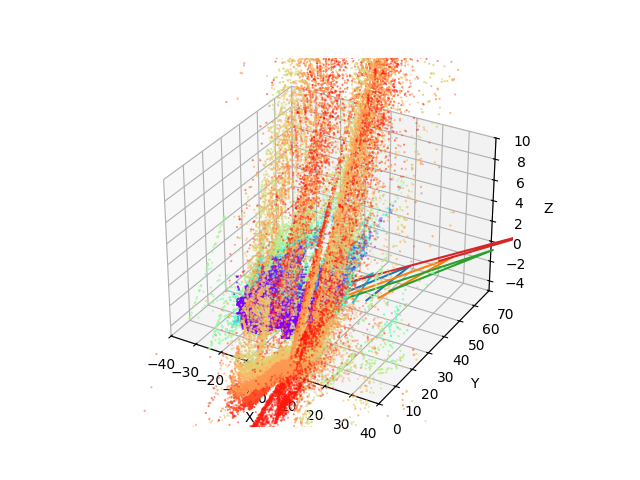

In [5]:
t_matrices = []
aligned_pc = []
n = num_of_frames
accumulated_transformation = np.eye(4)
accumulated_points = []
accumulated_translations = np.zeros(3)
points = []
colors = cm.rainbow(np.linspace(0, 1, n))
aligned_pc.append(np.column_stack((point_clouds[0],np.ones(point_clouds[0].shape[0]))))
ax = plt.figure().add_subplot(projection='3d')
for i in range(n - 1):
    tm, rmse = icp(point_clouds[i], point_clouds[i+1], epsilon=1e-20, max_iter = 500)
    R = np.linalg.inv(tm)[:3, :3]
    t = np.linalg.inv(tm)[:3, 3]
    if np.sqrt(t.dot(t)) < 2:
        accumulated_translations = t + accumulated_translations
    points.append(accumulated_translations)
    print(i, rmse)
    
    pts = np.append(point_clouds[i+1], [[1]] * point_clouds[i+1].shape[0], axis = 1)
    accumulated_transformation = np.linalg.inv(tm) @ accumulated_transformation
    print(accumulated_transformation)
    accumulated_points.append(accumulated_transformation[:3, 3])
    pts = np.dot(accumulated_transformation, pts.T)
    #pts = np.array([accumulated_transformation @ q for q in pts]).T
    size = len(point_clouds[i+1])
    choices = np.random.choice(size, size=5000, replace=False)

    x = pts[0][choices]
    y = pts[1][choices]
    z = pts[2][choices]
    ax.scatter(x, y, z, zdir='z', s=0.3, c=colors[i])

    aligned_pc.append(pts.T)
    t_matrices.append(np.linalg.inv(tm))

ax.plot(*accumulated_points)

ax.set_xlim(-40, 40)
ax.set_ylim(0, 70)
ax.set_zlim(-5, 10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

44.379863166820854


/tmp/ipykernel_8556/3957558144.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


0 1


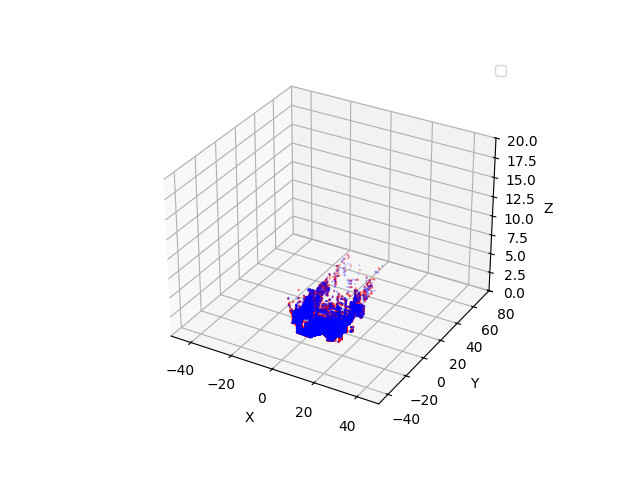

In [6]:
fi = 0
ff = 1

for i in range(fi ,ff):
    frame1 = i
    frame2 = i+1
    tm, rmse = icp(point_clouds[frame1], point_clouds[frame2], epsilon=1e-20, max_iter = 500)
    print(rmse)
    #print(tm, "\n\n")
    #print(np.linalg.inv(tm))
    
    ax = plt.figure().add_subplot(projection='3d')
    
    size = len(point_clouds[frame1])
    choices = np.random.choice(size, size=20000, replace=False)
    x = point_clouds[frame1].T[0][choices]
    y = point_clouds[frame1].T[1][choices]
    z = point_clouds[frame1].T[2][choices]
    ax.scatter(x, y, z, zdir='z', s=0.3, c='red')
    
    pts = np.append(point_clouds[frame2], [[1]] * point_clouds[frame2].shape[0], axis = 1)
    
    size = len(point_clouds[frame2])
    choices = np.random.choice(size, size=20000, replace=False)
    
    x = pts.T[0][choices]
    y = pts.T[1][choices]
    z = pts.T[2][choices]
    #ax.scatter(x, y, z, zdir='z', s=0.1, c='yellow')
    
    #for p in pts[:10]:
    #    print("=======\n", p)
    #    print(np.linalg.inv(tm) @ p)
    pts = np.array([np.linalg.inv(tm) @ q for q in pts]).T
    
    #p = p.T
    
    
    size = len(point_clouds[frame2])
    choices = np.random.choice(size, size=20000, replace=False)
    
    x = pts[0][choices]
    y = pts[1][choices]
    z = pts[2][choices]
    ax.scatter(x, y, z, zdir='z', s=0.1, c='blue')
    #ax.plot(*pos_to_plot_truth, c='blue')
    #ax.plot(*pos_to_plot, c='orange')
    
    ax.legend()
    
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 80)
    ax.set_zlim(0, 20)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    print(frame1, frame2)
    plt.show()

In [7]:
from math import factorial
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    """
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
    Data by Simplified Least Squares Procedures. Analytical
    Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
    W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
    Cambridge University Press ISBN-13: 9780521880688
    """
        
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except (ValueError):
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.asmatrix([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

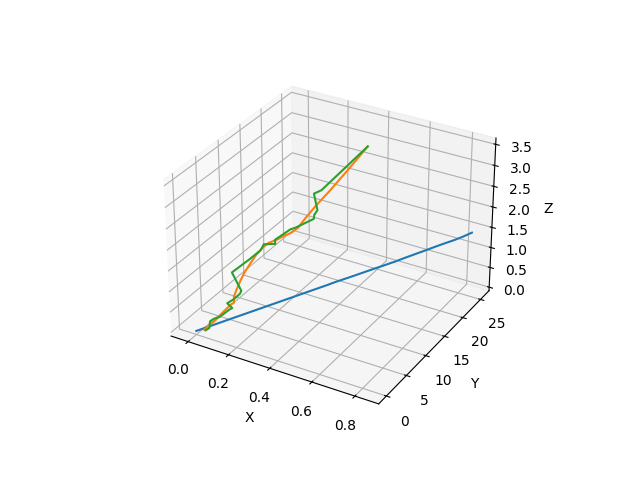

In [8]:
ax = plt.figure().add_subplot(projection='3d')
gt = np.load("ground_truth.npy")
gt_points = gt[:, :3, 3]
gt_points = gt_points.T

x = gt_points[1]
y = gt_points[2]
z = gt_points[0]
ax.plot(-x, y, -z)

x = savitzky_golay(np.asarray(points).T[0].copy(), 11, 3)
y = savitzky_golay(np.asarray(points).T[1].copy(), 11, 3)
z = savitzky_golay(np.asarray(points).T[2].copy(), 11, 3)
ax.plot(x, y, z)

x = np.asarray(points).T[0].copy()
y = np.asarray(points).T[1].copy()
z = np.asarray(points).T[2].copy()
ax.plot(x, y, z)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [9]:
import math
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])



[[ 9.89365831e-01  8.15024668e-02 -1.20468257e-01 -6.36943763e-18]
 [-4.74731252e-02  9.63843825e-01  2.62204852e-01 -1.02678428e-16]
 [ 1.37482927e-01 -2.53697516e-01  9.57463323e-01  5.52787738e-18]
 [-2.98862231e-13 -1.93259313e-13 -5.87583085e-14  1.00000000e+00]]


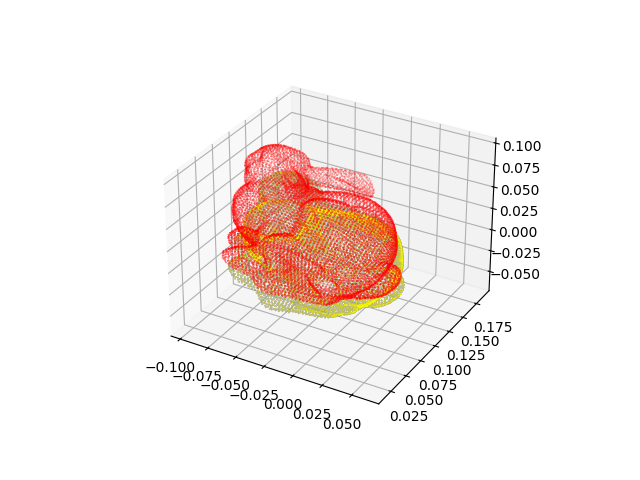

In [12]:
bunny_v = trimesh.load("bunny/reconstruction/bun_zipper_res2.ply").vertices
axis = [4, 2, 1]
theta = 0.3
ax = plt.figure().add_subplot(projection='3d')
bunny_v1 = np.dot(rotation_matrix(axis, theta), bunny_v.T)
ax.scatter(*(bunny_v.T), s=0.1, zdir='z', c='blue')
ax.scatter(*(bunny_v1), s=0.1, c='red', zdir='z')

tm, rmse = icp(bunny_v1.T, bunny_v, epsilon=1e-40, max_iter=25)
print(tm)
bunny_v1 = np.column_stack((bunny_v1.T,np.ones(bunny_v1.shape[1])))
bunny_v2 = np.dot(tm, bunny_v1.T)

ax.scatter(*(bunny_v2[:3]), s=0.1, c='yellow', zdir='z')

plt.show()